In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.pipeline import FeatureUnion
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

In [44]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [45]:
def show_roc_auc(y_test, y_score):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
    plt.show()

In [46]:
def conf_matr_show_TPR_FPR_TNR(y_test, y_score, thresholds):
    font = {'size' : 15}

    plt.rc('font', **font)

    cnf_matrix = confusion_matrix(y_test, y_score>thresholds)
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
    #plt.savefig("conf_matrix.png")
    plt.show()
    
    TN = cnf_matrix[0][0]
    FN = cnf_matrix[1][0]
    TP = cnf_matrix[1][1]
    FP = cnf_matrix[0][1]

    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)
    TNR = TN/(FP+TN)
    return TPR, FPR, TNR

In [47]:
def calc_pr_rec_fsc_thres(y_test_values, y_score):
    b=1
    precision, recall, thresholds = precision_recall_curve(y_test_values, y_score)
    fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
    return thresholds[ix], fscore[ix], precision[ix], recall[ix]

ссылка на соревнование - https://mlbootcamp.ru/ru/round/12/sandbox/

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

In [48]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Разделим наши данные на тренировочную и тестовую выборки

In [49]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [50]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [51]:
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

LogisticRegression

Добавим классификатор и запустим кросс-валидацию

In [52]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7867401104915408+-0.00852135511666111


Посчитаем best thresholds/precision/recall/f_score

In [53]:
thresholds, fscore, precision, recall = calc_pr_rec_fsc_thres(y_test.values, y_score)

Best Threshold=0.386937, F-Score=0.730, Precision=0.647, Recall=0.838


Нарисуем roc auc кривую (кстати, наверное неплохо бы ее вынести в отдельную функцию)

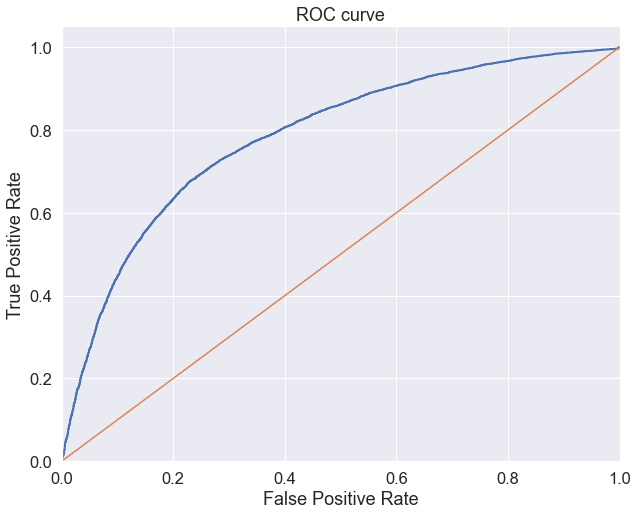

In [54]:
show_roc_auc(y_test, y_score)

In [55]:
roc_auc_score1 = roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])

print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))

roc auc score: 0.7840347790421852
log loss score: 0.5779604008230668


Посомтрим на матрицу ошибок

Confusion matrix, without normalization
[[4861 3959]
 [1411 7269]]


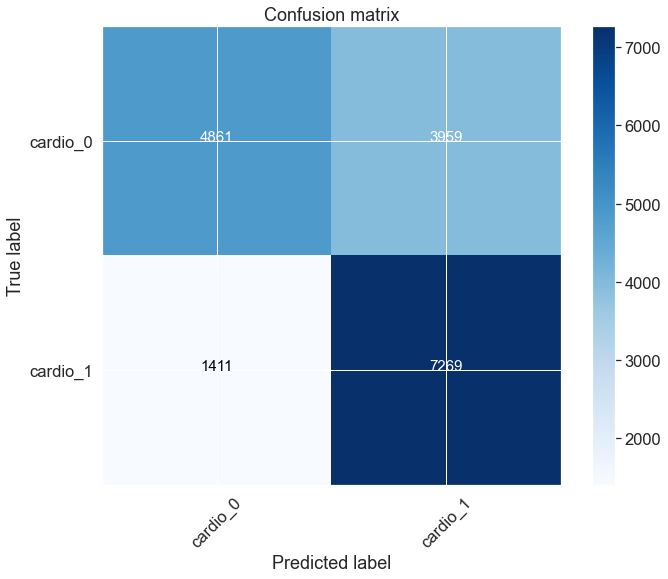

(0.837442396313364, 0.44886621315192743, 0.5511337868480726)

In [56]:
TPR, FPR, TNR = conf_matr_show_TPR_FPR_TNR(y_test, y_score, thresholds)
TPR, FPR, TNR

False Positive Rate довольно высокий ~ 0.45.

Это означает, что 45 процентов всех пациентов получат метку 1 при том, что они на самом деле здоровы

Хорошая ли модель у нас получилась? - ответ сильно зависит от внешних факторов (какое количество FP мы можем допустить)

Бустинг

In [57]:
import xgboost as xgb

In [58]:
classifier2 = Pipeline([
    ('features',feats),
    ('classifier', xgb.XGBClassifier(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores2 = cross_val_score(classifier2, X_train, y_train, cv=16, scoring='roc_auc')
cv_score2 = np.mean(cv_scores2)
cv_score_std2 = np.std(cv_scores2)
print('CV score is {}+-{}'.format(cv_score2, cv_score_std2))

#обучим пайплайн на всем тренировочном датасете
classifier2.fit(X_train, y_train)
y_score2 = classifier2.predict_proba(X_test)[:, 1]

CV score is 0.7974879407860951+-0.006447877492510205


In [59]:
thresholds2, fscore2, precision2, recall2 = calc_pr_rec_fsc_thres(y_test.values, y_score2)

Best Threshold=0.347103, F-Score=0.738, Precision=0.665, Recall=0.828


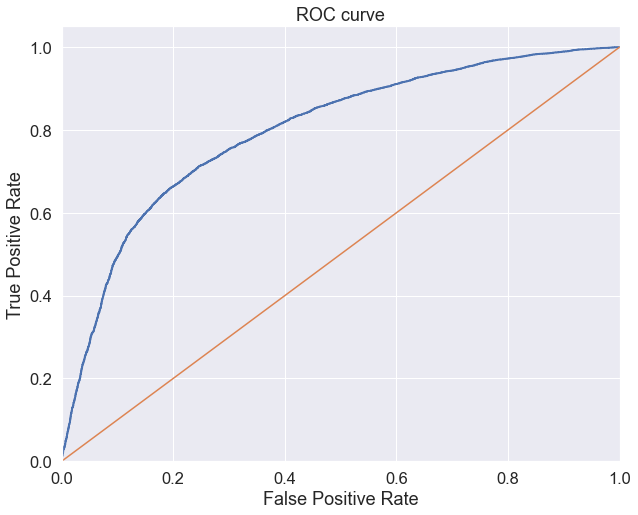

In [60]:
show_roc_auc(y_test, y_score2)

In [61]:
roc_auc_score2 = roc_auc_score(y_true=y_test, y_score=classifier2.predict_proba(X_test)[:,1])

print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier2.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier2.predict_proba(X_test)[:,1])))

roc auc score: 0.7972277670668882
log loss score: 0.5471106091668164


Confusion matrix, without normalization
[[5202 3618]
 [1491 7189]]


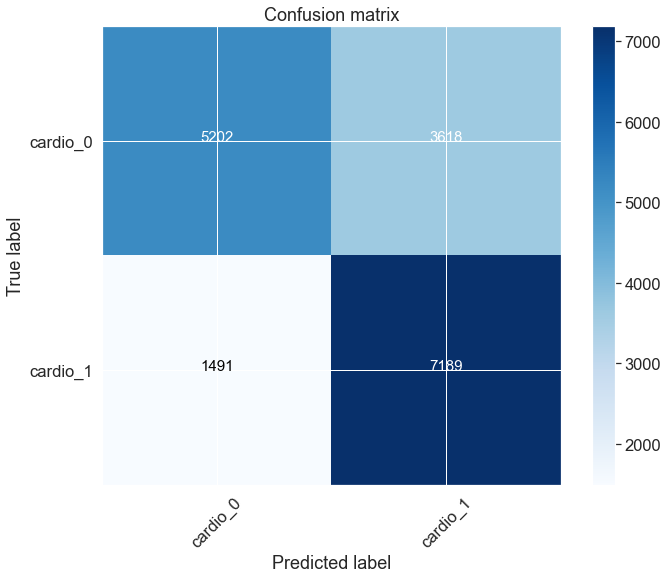

(0.8282258064516129, 0.41020408163265304, 0.5897959183673469)

In [62]:
TPR2, FPR2, TNR2 = conf_matr_show_TPR_FPR_TNR(y_test, y_score2, thresholds2)
TPR2, FPR2, TNR2

Лес

In [63]:
classifier3 = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores3 = cross_val_score(classifier3, X_train, y_train, cv=16, scoring='roc_auc')
cv_score3 = np.mean(cv_scores3)
cv_score_std3 = np.std(cv_scores3)
print('CV score is {}+-{}'.format(cv_score3, cv_score_std3))

#обучим пайплайн на всем тренировочном датасете
classifier3.fit(X_train, y_train)
y_score3 = classifier3.predict_proba(X_test)[:, 1]

CV score is 0.7734501681056019+-0.007171140345435727


In [64]:
thresholds3, fscore3, precision3, recall3 = calc_pr_rec_fsc_thres(y_test.values, y_score3)

Best Threshold=0.350000, F-Score=0.719, Precision=0.643, Recall=0.816


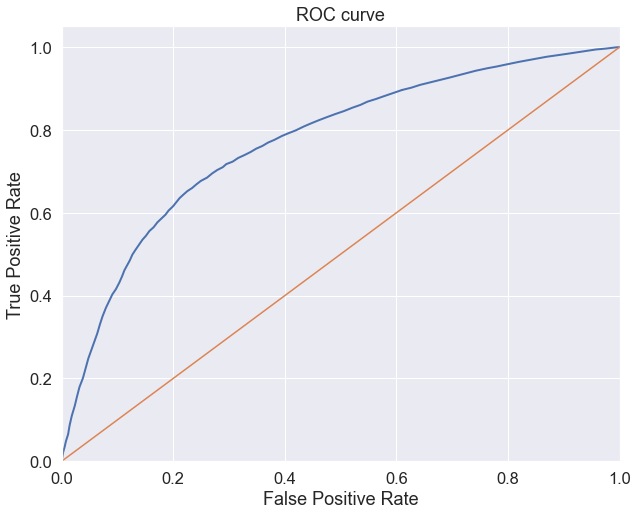

In [65]:
show_roc_auc(y_test, y_score3)

In [66]:
roc_auc_score3 = roc_auc_score(y_true=y_test, y_score=classifier3.predict_proba(X_test)[:,1])

print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier3.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier3.predict_proba(X_test)[:,1])))

roc auc score: 0.7710366181802983
log loss score: 0.5992984853728378


Confusion matrix, without normalization
[[4991 3829]
 [1663 7017]]


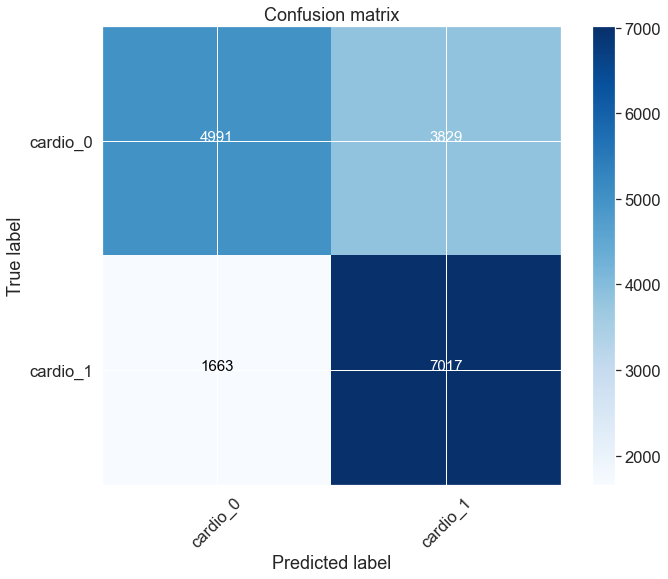

(0.8084101382488479, 0.43412698412698414, 0.5658730158730159)

In [67]:
TPR3, FPR3, TNR3 = conf_matr_show_TPR_FPR_TNR(y_test, y_score3, thresholds3)
TPR3, FPR3, TNR3

In [68]:
#TPR, FPR, TNR

In [69]:
result = {"F-Score":np.array([fscore, fscore2, fscore3]),
          "Precision":np.array([precision, precision2, precision3]),
          "Recall":np.array([recall, recall2, recall3]),
        "roc_auc_score": np.array([roc_auc_score1, roc_auc_score2, roc_auc_score3]),
         #"TPR": np.array([TPR, TPR2, TPR3]),
        # "FPR": np.array([FPR, FPR2, FPR3]),
        # "TNR": np.array([TNR, TNR2, TNR3])
         }

results = pd.DataFrame(result, index=['logreg', 'xgboost', 'randomforest'])
print(results)



               F-Score  Precision    Recall  roc_auc_score
logreg        0.730323   0.647431  0.837558       0.784035
xgboost       0.737890   0.665248  0.828341       0.797228
randomforest  0.718863   0.642669  0.815553       0.771037


Таким образом, лучшая модель получилась при использовании xgboost , далее логистическая регрессия и потом уже случайный лес, хотя значения скоринга(как roc-auc иак и f-score) длизки

### Домашнее задание

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

### Ссылки

1. https://dyakonov.org/2017/07/28/auc-roc-площадь-под-кривой-ошибок/
2. https://en.wikipedia.org/wiki/Receiver_operating_characteristic

In [8]:
# пример логрег на 1 примере


#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

classifier = Pipeline([('comment_text_selector', FeatureSelector(column='comment_text')), 
                     ('comment_text_tfidf', TfidfVectorizer(sublinear_tf=True,
                                                            strip_accents='unicode',
                                                            analyzer='word',
                                                            token_pattern=r'\w{1,}',
                                                            stop_words='english',
                                                            ngram_range=(1, 1),
                                                            max_features=10000)), 
                     ('clf', LogisticRegression(C=0.1, solver='sag'))])

#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=3, scoring='roc_auc')
cv_score = np.mean(cv_scores)
print('CV score is {}'.format(cv_score))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.9555025781738605
